In [1]:
from autoregressive_versus_teacher_forcing import *

MAX_SENTENCES = True
MAX_N_SENTENCES = 200

# Batch size
BATCH_SIZE = 8
N_BATCHES = 1  # -1 for all

# Decode sequence length
MAX_DEC_SEQ_LEN = -1 #for max_len

# Results
RESULT_DIR = 'evaluation-results'

# Whether or not to use cached keys and value in the autoregressive generation
USE_CACHE_AUTOREGRESS = True

def sentence_from_tok_ids(tok_ids_tensor, tokenizer_decoder):
    text = tokenizer_decoder.decode(tok_ids_tensor.tolist())
    if '<EOS>' in text:
        text = text.split('<EOS>')[0]
    return text

DEVICE: cpu


In [2]:
model_paths = get_all_model_paths()

tokenizer_encoder = MODEL_CLASSES[ENCODER_MODEL_TYPE][2].from_pretrained(ENCODER_MODEL_NAME, do_lower_case=DO_LOWERCASE)
_, tokenizer_decoder = get_model_tokenizer_decoder(model_paths['snli'][1.0]['decoder_path'], 'snli')

sentences = load_sentences(SENTENCES_FILE, max_N_sentences=MAX_SENTENCES, N_sentences=MAX_N_SENTENCES)
pad_tok_sent_dec, pad_tok_sent_enc = tokenise_pad_sentences(sentences, tokenizer_encoder, tokenizer_decoder)

n_batches = int(np.ceil(pad_tok_sent_enc.shape[0] / BATCH_SIZE))
N_BATCHES = n_batches if (N_BATCHES == - 1) else N_BATCHES

if MAX_DEC_SEQ_LEN != -1:
    pad_tok_sent_enc = pad_tok_sent_enc[:, :MAX_DEC_SEQ_LEN]
    pad_tok_sent_dec = pad_tok_sent_dec[:, :MAX_DEC_SEQ_LEN]

bert_sequence_batches = pad_tok_sent_enc.chunk(n_batches)
gpt2_sequence_batches = pad_tok_sent_dec.chunk(n_batches)

results_all_models = {}

snli_wikipedia = 'snli'
beta = 1.0

results_all_models[snli_wikipedia] = {}

print("-" * 30)
print("Configuration: {} - beta: {}".format(snli_wikipedia, beta))

pred_auto, ce_losses_auto, pred_tf, ce_losses_tf = [], [], [], []

VAE_model = load_model(model_paths, snli_wikipedia, beta)
VAE_model = VAE_model.to(DEVICE)

# Tokenizers should be the same for all models? Not sure actually
tokenizer_encoder = VAE_model.tokenizer_encoder
tokenizer_decoder = VAE_model.tokenizer_decoder

CONFIG: {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "latent_size": 768,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "vocab_size": 50260
}

Padded decoder GPT2 input/label sequence batch shape: torch.Size([200, 26])
Padded encoder BERT input sequence batch shape: torch.Size([200, 25])
------------------------------
Configuration: snli - beta: 1.0
CONFIG: {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_drop

In [3]:
for batch_i in range(n_batches):
    print("Batch {}".format(batch_i), end='\r')

    batch_inputs_bert = bert_sequence_batches[batch_i].to(DEVICE)
    batch_labels_gpt2 = gpt2_sequence_batches[batch_i].to(DEVICE)

    logits_au, logits_tf = encode_reconstruct_auto_and_tf(VAE_model,
                                                            batch_inputs_bert,
                                                            batch_labels_gpt2,
                                                            use_cache=True)
    

    all_logits_auto.append(logits_au.cpu())
    all_logits_tf.append(logits_tf.cpu())

    if batch_i == (N_BATCHES - 1):
        break
        
    break

# Add results to dict with all configurations
results_all_models[snli_wikipedia][beta] = {'logits_auto': torch.cat(all_logits_auto),
                                            'logits_tf': torch.cat(all_logits_tf)}

Autoregressive batch forward
torch.Size([8, 1])
torch.Size([8, 1])
Teacher force batch forward
torch.Size([8, 26, 50260])
torch.Size([8, 26, 50260])


RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, QuantizedCPU, Autograd, Profiler, Tracer, Autocast]

In [7]:
os.listdir('../data/datasets/snli_1.0/')



['snli_1.0_train.txt',
 '.DS_Store',
 'Icon\r',
 'snli_1.0_test.jsonl',
 'README.txt',
 'snli_1.0_dev.txt',
 'snli_1.0_dev.jsonl',
 'snli_1.0_test.txt',
 'snli_1.0_train.jsonl']

In [10]:
import pandas as pd

df = pd.read_table('../data/datasets/snli_1.0/snli_1.0_train.txt')
sentences = df[['sentence1']]


,sentence1
0,A person on a horse jumps over a broken down a...
1,A person on a horse jumps over a broken down a...
2,A person on a horse jumps over a broken down a...
3,Children smiling and waving at camera
4,Children smiling and waving at camera
...,...
550147,Four dirty and barefooted children.
550148,Four dirty and barefooted children.
550149,A man is surfing in a bodysuit in beautiful bl...
550150,A man is surfing in a bodysuit in beautiful bl...


In [18]:
sentences = df.sentence1.tolist()
sentences

['A person on a horse jumps over a broken down airplane.',
 'A person on a horse jumps over a broken down airplane.',
 'A person on a horse jumps over a broken down airplane.',
 'Children smiling and waving at camera',
 'Children smiling and waving at camera',
 'Children smiling and waving at camera',
 'A boy is jumping on skateboard in the middle of a red bridge.',
 'A boy is jumping on skateboard in the middle of a red bridge.',
 'A boy is jumping on skateboard in the middle of a red bridge.',
 'An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.',
 'An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.',
 'An older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background.',
 'Two blond women are hugging one another.',
 'Two blond women are 

(array([4.2070e+03, 4.5344e+04, 5.3134e+04, 2.8834e+04, 9.5940e+03,
        5.6070e+03, 2.2720e+03, 9.6200e+02, 4.1300e+02, 1.5800e+02,
        9.9000e+01, 4.8000e+01, 3.0000e+01, 1.4000e+01, 3.0000e+00,
        6.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 2. ,  5.8,  9.6, 13.4, 17.2, 21. , 24.8, 28.6, 32.4, 36.2, 40. ,
        43.8, 47.6, 51.4, 55.2, 59. , 62.8, 66.6, 70.4, 74.2, 78. ]),
 <BarContainer object of 20 artists>)

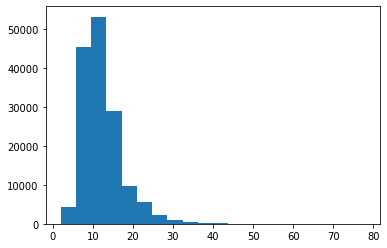

In [24]:
import matplotlib.pyplot as plt
lens = []
sentences = list(set(sentences))
for s in sentences:
    lens.append(len(s.split(' ')))
plt.hist(lens, bins=20)

In [34]:
# sentences = sorted(sentences, key=len)
len(sentences)

150736

In [29]:
with open("snli_sentences.txt", "a") as myfile:
    for s in sentences:
        myfile.write(s+'\n')

In [33]:
import pickle

with  as handle:
    

sentences2 = pickle.load(open('snli_sentences.pickle', 'rb'))

print(sentences == sentences2)

True
